# 0. Imports & utility

In [1]:
import os
import subprocess
import shlex
import re
from copy import copy
from itertools import chain
from collections import defaultdict

import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import display
        
from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
%load_ext rpy2.ipython


def pandas_r2py(name):
    '''Возвращает датафрейм name из рабочей среды R'''
    df = r(name)
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_from_pd_df = ro.conversion.rpy2py(df)
    return r_from_pd_df

def pandas_py2r(df, name):
    '''Записывает датафрейм df из среды Питона в среду R в переменную name'''
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_from_pd_df = ro.conversion.py2rpy(df)
    ro.globalenv[name] = r_from_pd_df

# 1. Run MiXCR on data from paper

https://www.ebi.ac.uk/ena/browser/view/PRJEB38339

```bash
mixcr analyze amplicon --species hs \
        --starting-material dna \
        --5-end v-primers \
        --3-end j-primers \
        --adapters adapters-present \
        --receptor-type TRB \
        TRB-Pt-10-1-500ng-09-04-2020-gDNA_S41_L001_R1_001.fastq TRB-Pt-10-1-500ng-09-04-2020-gDNA_S41_L001_R2_001.fastq results
```

In [ ]:
pattient_id_pattern = re.compile(r'Pt-[0-9]+-[0-9]+')
healthy_id_pattern = re.compile(r'HD[0-9]+')

s = """mixcr analyze amplicon --species hs \
        --starting-material dna \
        --5-end v-primers \
        --3-end j-primers \
        --adapters adapters-present \
        --receptor-type TRB """

template_command = shlex.split(s)

path = './'
for dirname in tqdm(os.listdir(path)):
    reads = {1: None, 2: None}
    for filename in os.listdir(path+dirname):
        if '_R1_' in filename:
            reads[1] = filename
        else:
            reads[2] = filename
            
    # Skip some strange ChristophS files
    if all(group not in reads[1] for group in ['HD', 'Pt']):
        continue
    
    # Don't need B cells
    if 'IGH' in reads[1]:
        continue

    m = re.search(pattient_id_pattern, reads[1])
    if not m:  # Didn't match
        m = re.search(healthy_id_pattern, reads[1]) 
    
    res_filename = m.group(0)
    
    command = copy(template_command)
    command.extend([reads[1], reads[2], res_filename])
    
    # Run bash 
    subprocess.run(command, cwd=path+dirname)

###  Copy files to relevant folders

In [ ]:
healthy_path = '../healthy/'
patient_path = '../patient/'

path = './'
for dirname in os.listdir(path):
    for filename in os.listdir(path + dirname):
        if filename.endswith('.txt'):
            
            command = ['cp', f'{path + dirname}/{filename}']
            
            if 'Pt' in filename:
                command.append(patient_path)
            else:
                command.append(healthy_path)
            
            subprocess.run(command, check=True)        

# 2. Building of a count matrix

In [3]:
def kmers(seq, k):
    """
    Генерирует к-меры по строке seq
    """
    for i in range(0, len(seq) - k + 1):
        yield i, seq[i:i+k]

def kmer_freq(df, most_common_count=1000, k=5, include_position=False, 
              cdr3_field='aaSeqCDR3', count_field='cloneCount'):
    """
    Возвращает словарь {kmer: относительная частота}
    """
    res = defaultdict(int)
    for i, row in df.iterrows():
        cdr3 = row[cdr3_field].replace('_', '').strip()
        for pos, kmer in kmers(cdr3, k=k):
            n = len(cdr3)
            key = kmer
            if include_position:
                if pos < n / 3 - k / 2:  # 
                    key += '1'
                elif pos < 2 * n / 3 - k / 2:
                    key += '2'
                else:
                    key += '3'
            res[key] += row[count_field]
            
    total = df[count_field].sum()
    for k, v in res.items():
        res[k] = v / total

    return defaultdict(int, {kmer: frequency for kmer, frequency \
         in sorted(list(res.items()), key=lambda x: -x[1])[:min(len(res), 
                                                                most_common_count)]})

def read_folder(path, k=6, count=300, include_position=False,
                count_field='cloneCount', cdr3_field='aaSeqCDR3'):
    """
    Возвращает список со словарями {кмер: относительная частота} для count самых частых
    6-меров для каждого файла, лежащего в каталоге path
    
    для данных из статьи:
    count_field = 'cloneCount' 
    cdr3_field = 'aaSeqCRD3' 
    
    для наших данных:
    count_field = 'count'
    crd3_field = 'cdr3aa'
    """
    data_list = []
    
    for filename in tqdm(os.listdir(path)):
        df = pd.read_csv(path + filename, sep='\t')
        # display(df)
        data_list.append(kmer_freq(df[[count_field, cdr3_field]], 
                                   most_common_count=count, k=k,
                                   include_position=include_position,
                                   count_field=count_field,
                                   cdr3_field=cdr3_field))
    return data_list

def find_unique_kmers(*args):
    """
    args - lists of dictionaries
    
    Returns a set with all unique kmers encountered as key in args
    """
    unique_kmers = set()
    for arg in args:
        for subj in arg:
            unique_kmers |= subj.keys()
    assert all(uk.isalpha() for uk in unique_kmers), "Some kmers are invalid"
    return unique_kmers


def construct_count_matrix(control=None, patients=None):

    dicts = []
    unique_kmers = find_unique_kmers(control, patients)
    
    for subj in patients:
        tmp = {'target': 1}
        for uk in unique_kmers:
            tmp[uk] = subj[uk]
        dicts.append(tmp)

    for subj in control:
        tmp = {'target': 0}
        for uk in unique_kmers:
            tmp[uk] = subj[uk]
        dicts.append(tmp)

    count_matrix = pd.DataFrame(dicts)
    
#     X = count_matrix.drop(columns=['target'])
#     y = count_matrix['target']
#     return X, y
    
    return count_matrix

# 3. Model on paper data

In [88]:
%ls

articles/            file2_1.txt          SampleClassification.ipynb
epitope-classifier/  file2_2.txt          sample-classifier/
file1_1.txt          MiXCR_scripts.ipynb  sample.csv
file1_2.txt          README.md


In [89]:
patient_path = 'use_of_ml_paper_data/patient/recovered/'
healthy_path = 'use_of_ml_paper_data/healthy/'

k = 6
count = 400
position = False

patients = read_folder(patient_path, k=k, count=count, include_position=position)
control = read_folder(healthy_path, k=k, count=count, include_position=position)
count_matrix = construct_count_matrix(control, patients)
display(count_matrix.head())

# запись в среду R
pandas_py2r(count_matrix, 'paper_data')

 16%|█▌        | 3/19 [00:03<00:22,  1.38s/it]/home/iam28th/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
 79%|███████▉  | 15/19 [00:25<00:08,  2.14s/it]/home/iam28th/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (8,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
100%|██████████| 38/38 [00:28<00:00,  1.35it/s]


,target,GTNTGE,SRPDRV,SYSNRN,SAGTGE,VVQGSN,SERTFY,ISGPVG,SVLGSD,PRNTEA,...,CASSAP,LGVREL,TQETQY,TGTYEQ,GEVEQF,SRPSGG,RARTGE,TSGRLN,TNTGEL,QAHSPL
0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.003032,0.0
1,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.003259,0.0
2,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00295,0.0,0.0,0.0,0.0,0.0,0.005600,0.0
3,1,0.001953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.004917,0.0
4,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.003002,0.0


### Fitting 

Random Forest 

57 samples
10 predictors
 2 classes: '0', '1' 

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 56, 56, 56, 56, 56, 56, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0,7017544  0,3200000
   3    0,7192982  0,3684211
   4    0,7017544  0,3200000
   5    0,7192982  0,3684211
   6    0,7192982  0,3684211
   7    0,7017544  0,3200000
   8    0,7368421  0,4000000
   9    0,7017544  0,3200000
  10    0,7017544  0,3200000

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 8.

Call:
 randomForest(x = x, y = y, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 8

        OOB estimate of  error rate: 28,07%
Confusion matrix:
   0  1 class.error
0 31  7   0,1842105
1  9 10   0,4736842


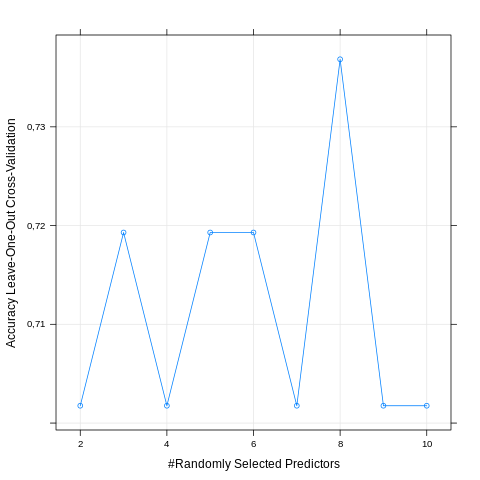

In [92]:
%%R
set.seed(28)

y = as.factor(unlist(paper_data['target']))
X = subset(paper_data, select=-c(target))

X_pca = prcomp(X, scale=F)$x[, 1:10]

loocv = caret::trainControl(method='LOOCV', search='grid')
model = caret::train(x=X_pca, y=y, method='rf', trControl=loocv, tuneLength=9)

print(model)
print(model$finalModel)
plot(model)

---
Having trouble with convalescent samples... Tried different k with/without checking position, yet to no avail.

# 4. Model on our data

In [5]:
patient_path = 'convalescent/'
healthy_path = 'healthy/'

k = 6
count = 400
position = False
position

# count_field_name = 'count'
# aa_crd3_field = 'crd3aa'

patients = read_folder(patient_path, k=k, count=count, include_position=position, 
                       count_field='count', cdr3_field='cdr3aa')
control = read_folder(healthy_path, k=k, count=count, include_position=position, 
                       count_field='count', cdr3_field='cdr3aa')
count_matrix = construct_count_matrix(control, patients)
display(count_matrix.head())

# запись в среду R
pandas_py2r(count_matrix, 'our_data')

100%|██████████| 14/14 [01:07<00:00,  4.80s/it]


,target,CASRIG,RDTEAF,SYRRPS,CASSQT,SLVAGY,SATPLA,GNTEAF,LNTGEL,SGRGVD,...,QVYGTF,RQETQY,SGELFF,DGTIRS,SSEAWE,RRTVLW,RDHTGE,RAWNNE,SLIAGT,GLGADT
0,1,0.0,0.0,0.00000,0.001790,0.0,0.0,0.004800,0.0,0.00000,...,0.0,0.00000,0.002520,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.00000,0.002470,0.0,0.0,0.005940,0.0,0.00000,...,0.0,0.00181,0.003040,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.00362,0.000000,0.0,0.0,0.005230,0.0,0.00000,...,0.0,0.00000,0.002930,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.00000,0.003520,0.0,0.0,0.005480,0.0,0.00386,...,0.0,0.00207,0.003780,0.0,0.00219,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.00000,0.002554,0.0,0.0,0.005068,0.0,0.00000,...,0.0,0.00000,0.002905,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


R[write to console]: Loading required package: lattice

R[write to console]: Loading required package: ggplot2



Random Forest 

34 samples
10 predictors
 2 classes: '0', '1' 

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 33, 33, 33, 33, 33, 33, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa     
   2    0.5588235  0.01544402
   3    0.5882353  0.09160305
   4    0.5882353  0.11194030
   5    0.5882353  0.11194030
   6    0.6176471  0.18450185
   7    0.5294118  0.00729927
   8    0.5882353  0.13138686
   9    0.5882353  0.13138686
  10    0.5882353  0.13138686

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 6.

Call:
 randomForest(x = x, y = y, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 6

        OOB estimate of  error rate: 50%
Confusion matrix:
  0  1 class.error
0 4 10   0.7142857
1 7 13   0.3500000


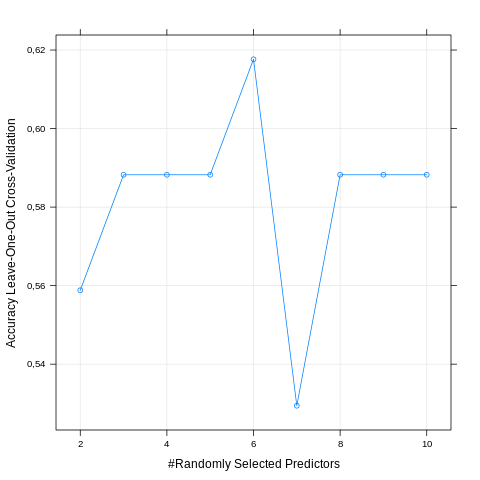

In [6]:
%%R
set.seed(28)

y = as.factor(unlist(our_data['target']))
X = subset(our_data, select=-c(target))

X_pca = prcomp(X, scale=F)$x[, 1:10]

loocv = caret::trainControl(method='LOOCV', search='grid')
model = caret::train(x=X_pca, y=y, method='rf', trControl=loocv, tuneLength=9)

print(model)
print(model$finalModel)
plot(model)